In [1]:
ifile = '../data/corrected.tsv'
sfile = '../data/ko_scores.tsv'
dfile = '../out/deviating.tsv'
cfile = '../data/conditions.tsv'
# pfile = '../natural_isolates/out/sickness.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
def fix_conditions(values, cfile=cfile):
    ctable = pd.read_table(cfile, index_col=0)
    correct = ctable['corrected_condition_tag'].dropna().to_dict()
    ctable = ctable['condition'].dropna().to_dict()
    c = {x: ctable.get(correct.get(x.split('-')[1].lower(),
                                   x.split('-')[1].lower()),
                       correct.get(x.split('-')[1].lower(),
                                   x.split('-')[1].lower())) +
         ' (' + x.split('-')[0].upper() + ')'
         for x in set(values)}

    return [c[x] for x in values]

In [5]:
# paf = pd.read_table(pfile, index_col=0)
# paf = paf[['ADA', 'SACE_GAT']]
# paf = paf.rename(columns={'ADA': 'Y55',
#                           'SACE_GAT': 'UWOP'})
# paf[paf >= 0.9] = 1
# paf[paf < 0.9] = 0

In [6]:
dev = pd.read_table(dfile)
dev = dev[dev['strain2'] == 'S288C']

In [7]:
md1 = dev[(dev['phenotype1']) &
          (dev['qval'] < 1e-2)].groupby(['strain1', 'condition']).count()['qval'] / dev[(dev['phenotype1']) |
                                                                                        (dev['phenotype2'])].groupby(['strain1', 'condition']).nunique()['gene']
md2 = dev[(dev['phenotype2']) &
          (dev['qval'] < 1e-2)].groupby(['strain1', 'condition']).count()['qval'] / dev[(dev['phenotype1']) |
                                                                                        (dev['phenotype2'])].groupby(['strain1', 'condition']).nunique()['gene']
md3 = dev[dev['qval'] < 1e-2].groupby(['strain1', 'condition']).count()['qval'] / dev[(dev['phenotype1']) |
                                                                                      (dev['phenotype2'])].groupby(['strain1', 'condition']).nunique()['gene']

In [8]:
a = pd.read_table(sfile,
                  index_col=[2, 1])
a = a[(a['gene'] != 'WT')]
a['phenotype'] = a['qvalue'] <= 0.05

In [9]:
a = a.reset_index()
a['condition'] = fix_conditions(a['condition'])
a = a.set_index(['strain', 'condition'])

In [10]:
m = pd.read_table(ifile)
m['condition'] = fix_conditions(m['condition'])

In [11]:
m = m.set_index(['plate', 'row', 'column']).sort_index()

In [12]:
to_drop = !curl --silent "https://docs.google.com/spreadsheets/d/14i_5lWftFKMTwS4dOWULescrMCizwndyP-k6Y-P_SoI/export?gid=1038680574&format=tsv"
to_drop = {(int(x.split('__')[-1][:2]),
            int(x.split('__')[-1][2:4]),
            int(x.split('__')[-1][4:]))
           for x in to_drop
           if not x.startswith('#')}
to_drop = to_drop.union({x for x, v in zip(m.index,
                                           m['strain'].values)
                         if v == 'X'
                         or v.startswith('PBY')
                         or v.startswith('WT')})

In [13]:
m = m.drop(index=to_drop)

In [14]:
keep = {'%02d_%02d_%02d' % (x, y, z)
        for x, y, z in m.index}
a = a[a['position'].isin(keep)]

In [15]:
a = a.reset_index()
a = a.set_index(['strain', 'condition'])

In [16]:
mm = m.groupby(['condition', 'replica', 'batch', 'background']).median()

In [17]:
mc = mm.groupby(['condition',
                 'replica',
                 'batch'])['normalized'].count()

In [18]:
conds = mc[mc == 4].index

In [19]:
mm = mm.reset_index().set_index(['condition',
                                 'replica',
                                 'batch']).loc[conds].reset_index().set_index(['condition',
                                                                               'replica',
                                                                               'batch',
                                                                               'background'])

In [20]:
res = []
for x, y, z in {(x, y, z)
                for x, y, z, w in mm.index}:
    ref = mm.loc[(x, y, z, 'S288C'), 'normalized']
    for strain in ['UWOP', 'Y55', 'YPS']:
        t = mm.loc[(x, y, z, strain), 'normalized'] / ref
        res.append([x, y, z, '-'.join([x, y, z]), strain, t])
    res.append([x, y, z,
                '-'.join([x, y, z]),
                'S288C', 1.0])
r = pd.DataFrame(res,
                 columns=['condition',
                          'replica',
                          'batch',
                          'cstr',
                          'strain',
                          'v'])

In [21]:
conds = {x for x in a.reset_index()['condition']}
r = r[r['condition'].isin(conds)]

In [22]:
r[r['strain'] != 'S288C'][['condition',
                           'replica',
                           'batch',
                           'strain',
                           'v']].rename(columns={'v':
                                                 'relative-fitness'}).to_csv('relative_fitness.tsv',
                                                                             sep='\t',
                                                                             index=False)

In [23]:
r['absv'] = np.log2(r['v']).abs()

In [24]:
order = r.groupby('condition')['absv'].max().sort_values(ascending=False).index

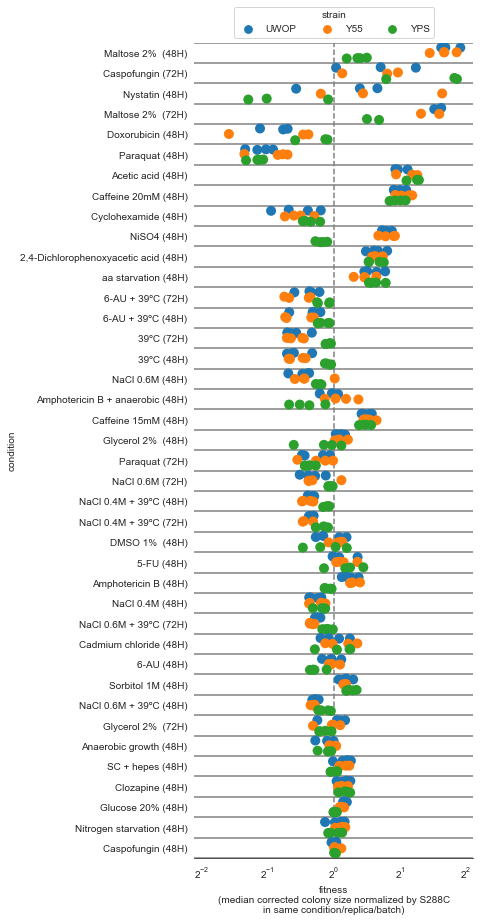

In [25]:
plt.figure(figsize=(5, 15))

sns.stripplot(data=r[r['strain'] != 'S288C'],
              x='v',
              y='condition',
              hue='strain',
              order=order,
              size=10,
              dodge=True)

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.axhline(-0.5,
            color='grey')
for i in range(len(r['condition'].unique())):
    plt.axhline(i+0.5,
                color='grey')

plt.xlabel('fitness\n(median corrected colony size normalized by S288C\nin same condition/replica/batch)')

plt.legend(bbox_to_anchor=(0.5, 1),
           loc='lower center',
           ncol=3,
           title='strain')

plt.xscale('log', basex=2)

sns.despine(left=True);

In [26]:
strains = ['UWOP',
           'YPS',
           'Y55']
mstrains = ['UWOP',
            'Y55']

In [27]:
r1 = r.set_index(['strain', 'condition']).sort_index().loc[strains]

In [28]:
a1 = a.groupby(['strain', 'condition'])['phenotype'].sum().sort_index()

In [29]:
a1 = (a1 / a1.loc['S288C']).loc[strains]

In [30]:
res = []
for (strain, cond), v1 in a1.iteritems():
    for v2 in r1.loc[(strain, cond), 'v'].values:
#         if strain not in mstrains:
        mut1 = np.nan
        mut2 = np.nan
        mut3 = np.nan
#         else:
#             gene1 = set(a[a['phenotype']].loc[('S288C', cond), 'gene'].values).difference(a[a['phenotype']].loc[(strain, cond), 'gene'].values)
#             gene2 = set(a[a['phenotype']].loc[(strain, cond), 'gene'].values).difference(a[a['phenotype']].loc[('S288C', cond), 'gene'].values)
#             gene3 = set(a[a['phenotype']].loc[(strain, cond), 'gene'].values).union(a[a['phenotype']].loc[('S288C', cond), 'gene'].values)
#             mut1 = paf[strain].loc[gene1].sum() / len(gene1)
#             mut2 = paf[strain].loc[gene2].sum() / len(gene2)
#             mut3 = paf[strain].loc[gene3].sum() / len(gene3)
        res.append((strain, cond,
                    v1, v2,
                    md1.reindex([(strain, cond),]).values[0],
                    md2.reindex([(strain, cond),]).values[0],
                    md3.reindex([(strain, cond),]).values[0],
                    np.log2(v1), np.log2(v2),
                    mut1, mut2, mut3))
p = pd.DataFrame(res,
                 columns=['strain',
                          'condition',
                          'phenotypes',
                          'fitness',
                          'deviations1',
                          'deviations2',
                          'deviations',
                          'lphenotypes',
                          'lfitness',
                          'mut1', 'mut2', 'mut3'])

In [31]:
# plt.figure(figsize=(4, 4))

# sns.scatterplot(x='fitness',
#                 y='mut3',
#                 hue='strain',
#                 data=p[p['strain'].isin(mstrains)])

# plt.axvline(1,
#             color='grey',
#             ls='dashed')

# plt.xscale('log', basex=2)
# # plt.yscale('log', basey=2)

# plt.legend(bbox_to_anchor=(1, 1),
#            loc='upper left')

# plt.xlabel('fitness\n(compared to S288C)')
# plt.ylabel('mutations');

In [32]:
# plt.figure(figsize=(4, 4))

# sns.scatterplot(x='fitness',
#                 y='mut3',
#                 hue='strain',
#                 data=p.groupby(['strain', 'condition']).mean().loc[mstrains].reset_index())

# plt.axvline(1,
#             color='grey',
#             ls='dashed')

# plt.xscale('log', basex=2)
# # plt.yscale('log', basey=2)

# plt.legend(bbox_to_anchor=(1, 1),
#            loc='upper left')

# plt.xlabel('fitness\n(compared to S288C)')
# plt.ylabel('mutations');

In [33]:
# x = sns.lmplot(x='lfitness',
#                y='mut3',
#                col='strain',
#                data=p.groupby(['strain', 'condition']).mean().loc[mstrains].reset_index(),
#                height=4)

# for ax in x.axes[0]:
#     plt.sca(ax)

#     plt.axvline(0,
#                 color='grey',
#                 ls='dashed')

#     plt.xlabel('fitness\n(compared to S288C)')
#     plt.ylabel('mutations');

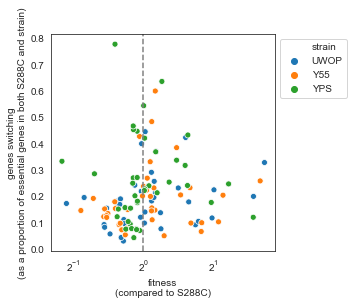

In [34]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='deviations',
                hue='strain',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
# plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left')

plt.xlabel('fitness\n(compared to S288C)')
plt.ylabel('genes switching\n(as a proportion of essential genes in both S288C and strain)');

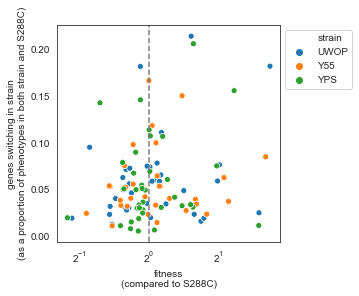

In [35]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='deviations1',
                hue='strain',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
# plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left')

plt.xlabel('fitness\n(compared to S288C)')
plt.ylabel('genes switching in strain\n(as a proportion of phenotypes in both strain and S288C)');

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


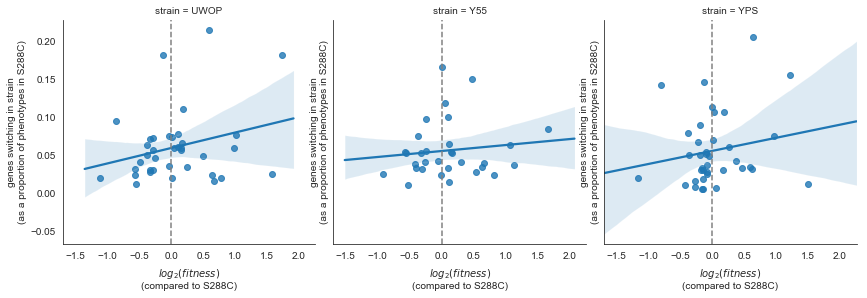

In [36]:
x = sns.lmplot(x='lfitness',
               y='deviations1',
               col='strain',
               data=p.groupby(['strain', 'condition']).mean().reset_index(),
               height=4)

for ax in x.axes[0]:
    plt.sca(ax)

    plt.axvline(0,
                color='grey',
                ls='dashed')

    plt.xlabel('$log_{2}(fitness)$\n(compared to S288C)')
    plt.ylabel('genes switching in strain\n(as a proportion of phenotypes in S288C)');

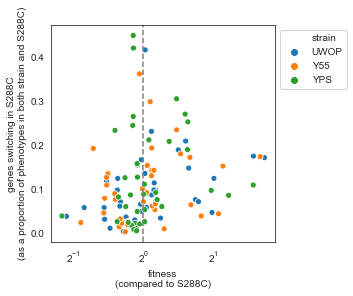

In [37]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='deviations2',
                hue='strain',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
# plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left')

plt.xlabel('fitness\n(compared to S288C)')
plt.ylabel('genes switching in S288C\n(as a proportion of phenotypes in both strain and S288C)');

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


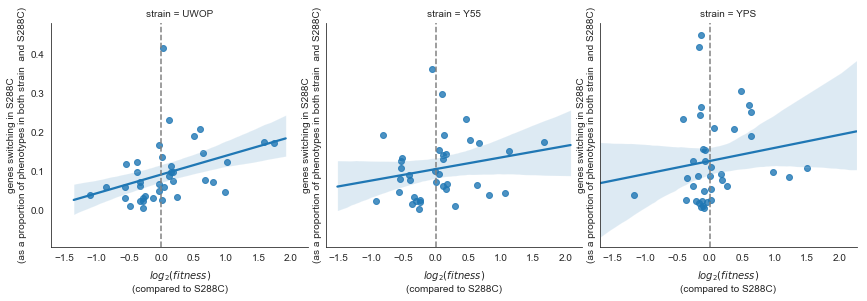

In [38]:
x = sns.lmplot(x='lfitness',
               y='deviations2',
               col='strain',
               data=p.groupby(['strain', 'condition']).mean().reset_index(),
               height=4)

for ax in x.axes[0]:
    plt.sca(ax)

    plt.axvline(0,
                color='grey',
                ls='dashed')

    plt.xlabel('$log_{2}(fitness)$\n(compared to S288C)')
    plt.ylabel('genes switching in S288C\n(as a proportion of phenotypes in both strain  and S288C)');

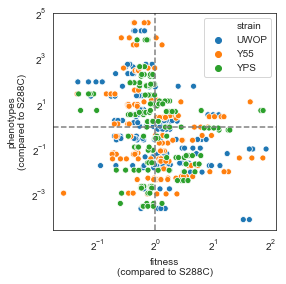

In [39]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='strain',
                data=p)

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.xlabel('fitness\n(compared to S288C)')
plt.ylabel('phenotypes\n(compared to S288C)');

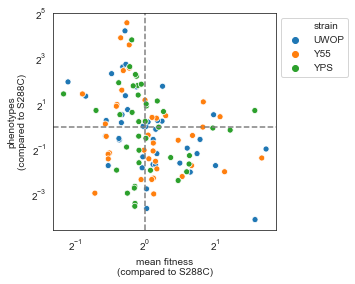

In [40]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='strain',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           ncol=1)

plt.xlabel('mean fitness\n(compared to S288C)')
plt.ylabel('phenotypes\n(compared to S288C)');

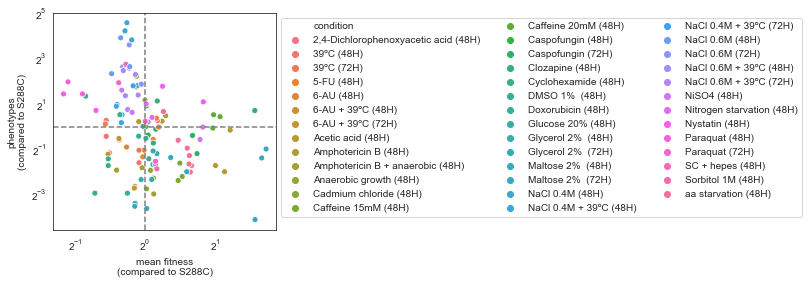

In [41]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='condition',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           ncol=3)

plt.xlabel('mean fitness\n(compared to S288C)')
plt.ylabel('phenotypes\n(compared to S288C)');

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


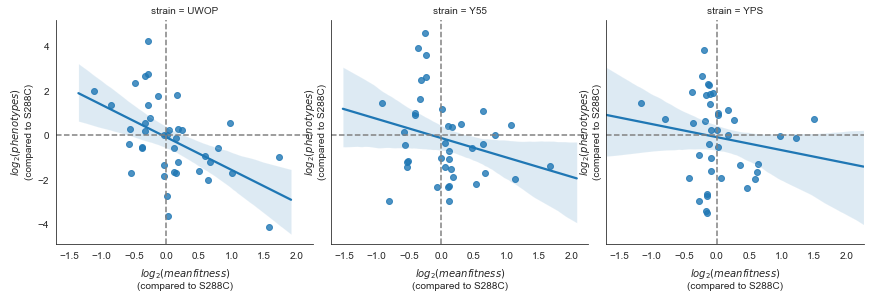

In [42]:
x = sns.lmplot(x='lfitness',
               y='lphenotypes',
               data=p.groupby(['strain', 'condition']).mean().reset_index(),
               col='strain',
               height=4,
               palette=sns.color_palette('Set2', 3))

for ax in x.axes[0]:
    plt.sca(ax)
    plt.axvline(0,
                color='grey',
                ls='dashed')
    plt.axhline(0,
                color='grey',
                ls='dashed')

#     plt.xscale('log', basex=2)
#     plt.yscale('log', basey=2)

    plt.xlabel('$log_{2}(mean fitness)$\n(compared to S288C)')
    plt.ylabel('$log_{2}(phenotypes)$\n(compared to S288C)');